# TF-IDF with Chi-Squared 
Here is a description

## Imports and Setup

### Install missing packages

In [1]:
!pip install nltk
!pip install gensim
!pip install python-Levenshtein

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import glob

from transformers import BertTokenizer
from transformers import BertModel
from transformers import AutoModel
from transformers import AutoTokenizer

from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

In [423]:
import xml.etree.ElementTree as ET

from nltk.probability import FreqDist

from functools import reduce
from nltk import ngrams
# Used for building models for classifying:
from pprint import pprint
from time import time
import logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [424]:
import time

### Define Constants

In [154]:
############### THIS IS THE MAX ACCEPTABLE LENGTH (80 CHARS) ###################
#data = "~/shared/data/project/training/one_hour"
TRAIN_DATA_LOCATION = "train.pkl"
TEST_DATA_LOCATION = "test.pkl"
VAL_DATA_LOCATION = "val.pkl"
random.seed(123)

namespace = "{http://www.tei-c.org/ns/1.0}"

N_LANGUAGES = 5

### Read in the data

In [385]:
df_train = pd.read_pickle(TRAIN_DATA_LOCATION)
df_test = pd.read_pickle(TEST_DATA_LOCATION)
df_val = pd.read_pickle(VAL_DATA_LOCATION)

In [386]:
print("TRAINING DATASET:")
print("Type: " + str(type(df_train)))
#print(train_data.head(3))
print("shape:" + str(df_train.shape))
#print(df_train.columns)
print("------------------------")
print("TESTING DATASET:")
print("Type: " + str(type(df_test)))
#print(test_data.head(3))
print("shape:" + str(df_test.shape))
#print(df_test.columns)
print("------------------------")
print("VALIDATION DATASET:")
print("Type: " + str(type(df_val)))
#print(test_data.head(3))
print("shape:" + str(df_val.shape))
#print(df_val.columns)

TRAINING DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(835033, 24)
------------------------
TESTING DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(56714, 24)
------------------------
VALIDATION DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(84377, 24)


In [387]:
# Sample to smaller sets for testing:
df_train = df_train[df_train["language"] == '488B32D24BD4BB44172EB981C1BCA6FA']
df_test = df_test[df_test["language"] == '488B32D24BD4BB44172EB981C1BCA6FA']
df_val = df_val[df_val["language"] == '488B32D24BD4BB44172EB981C1BCA6FA']

# Take a small dataset for developing
df_train = df_train.head(5000)
df_test = df_test.head(1000)
df_val = df_val.head(1000)

df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_val = df_val.reset_index()

### Understand the data

In [388]:
print("TRAINING DATASET:")
print("Type: " + str(type(df_train)))
#print(train_data.head(3))
print("shape:" + str(df_train.shape))
#print(df_train.columns)
print("------------------------")
print("TESTING DATASET:")
print("Type: " + str(type(df_test)))
#print(test_data.head(3))
print("shape:" + str(df_test.shape))
#print(df_test.columns)
print("------------------------")
print("VALIDATION DATASET:")
print("Type: " + str(type(df_val)))
#print(test_data.head(3))
print("shape:" + str(df_val.shape))
#print(df_val.columns)

TRAINING DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(5000, 25)
------------------------
TESTING DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(1000, 25)
------------------------
VALIDATION DATASET:
Type: <class 'pandas.core.frame.DataFrame'>
shape:(1000, 25)


## Preprocessing
Largely stolen from Tom. Needs some cleaning still

In [158]:
def preprocess(df):
    userIds = df.user_id_engaging.unique()
    userIds.sort()
    m = userIds.size

    tweetIds = df.tweet_id.unique()
    tweetIds.sort()
    n = tweetIds.size

    numEngagements = len(df)

    print ("There are", m, "users,", n, "tweets and", numEngagements, "recorded engagements.")

    ## Stolen from Tom - Not sure why though
    tweetId_to_tweetIDX = dict(zip(tweetIds, range(0, tweetIds.size)))
    tweetIDX_to_tweetId = dict(zip(range(0, tweetIds.size), tweetIds))

    userId_to_userIDX = dict(zip(userIds, range(0, userIds.size )))
    userIDX_to_userId = dict(zip(range(0, userIds.size), userIds))

    engagements = pd.concat([df['user_id_engaging'].map(userId_to_userIDX)
                             , df['tweet_id'].map(tweetId_to_tweetIDX)
                             , df['reply_engagement_timestamp']
                             , df['retweet_engagement_timestamp']
                             , df['retweet_with_comment_engagement_timestamp']
                             , df['like_engagement_timestamp']
                             , df['language']
                             , df['text_tokens']
                            ]
                             
                            , axis=1
                           )
    engagements.columns = ['user', 'tweet', 'reply', 'retweet', 'retweet_comment', 'like', 'language', 'text_tokens']

    
    
    columns = engagements[['reply', 'retweet', 'retweet_comment', 'like']]
    for col in columns:
        engagements.loc[~engagements[col].isna(), col] = 1
        engagements.loc[engagements[col].isna(), col] = 0

    ## Generate tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

    ## Detokenize
    #### Still need to fix the special tokens - they fudge up the predictions later
    engagements['text'] = engagements.apply(lambda row : tokenizer.decode(row['text_tokens']
                                                                          , add_special_tokens=False)
                                 , axis = 1)

    ## Clean up mess - No longer needed (I think) - Either that, or skip decoding at the first place
    engagements.drop('text_tokens', axis=1, inplace=True)
    engagements.head(5)

    engagements['reply'].value_counts()
    engagements['retweet'].value_counts()
    engagements['retweet_comment'].value_counts()
    
    user_counts = engagements['user'].value_counts()
    
    return engagements

In [159]:
train_data = preprocess(df_train)
test_data = preprocess(df_test)
val_data = preprocess(df_val)

There are 4974 users, 1162 tweets and 5000 recorded engagements.
There are 1000 users, 337 tweets and 1000 recorded engagements.
There are 1000 users, 531 tweets and 1000 recorded engagements.


In [165]:
train_data.head()

user  tweet  reply  retweet  retweet_comment  like  \
0   316   1044    0.0      0.0              0.0   1.0   
1   613   1044    0.0      1.0              0.0   1.0   
2  3272    538    0.0      0.0              0.0   0.0   
3  3089    352    0.0      0.0              0.0   1.0   
4   455    617    0.0      0.0              0.0   0.0   

                           language  \
0  488B32D24BD4BB44172EB981C1BCA6FA   
1  488B32D24BD4BB44172EB981C1BCA6FA   
2  488B32D24BD4BB44172EB981C1BCA6FA   
3  488B32D24BD4BB44172EB981C1BCA6FA   
4  488B32D24BD4BB44172EB981C1BCA6FA   

                                                                                                                                                                                                                                                                                                                                                     text  
0  [CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockosrocket @ Maddiewasmatty @ TS _ PlayAround @ Travel4TG @ AlenaTgirl2 @ tshunter007 @ GloriusShemale @ TransXHub @ ShemalesOnCams @ TsQueen _ Diana @ Sissy _ Trainers @ Alicia _ Smith993 @ nasshemia @ Here _ Diversity @ PassiValerio @ HyperLust69 @ Jamie _ Fiel https : / / t. co / 77RC28hYC8 [SEP]  
1  [CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockosrocket @ Maddiewasmatty @ TS _ PlayAround @ Travel4TG @ AlenaTgirl2 @ tshunter007 @ GloriusShemale @ TransXHub @ ShemalesOnCams @ TsQueen _ Diana @ Sissy _ Trainers @ Alicia _ Smith993 @ nasshemia @ Here _ Diversity @ PassiValerio @ HyperLust69 @ Jamie _ Fiel https : / / t. co / 77RC28hYC8 [SEP]  
2                                                                                                                                       [CLS] [UNK] " elevated " ( non - severe ) thunderstorms tomorrow... ¶ ¶ Another look at the timing & amp ; your 7 Day Forecast coming up in 15 minutes on @ CBS _ 42. # alwx https : / / t. co / dHvhmvKKxm [SEP]  
3                                                                                                                                                                                                                                                                 [CLS] [UNK] # CHENLE # 천러 ¶ © & amp ; dolphin 1122 https : / / t. co / Vl0BMfU0CZ [SEP]  
4                                                                                                                        [CLS] [UNK] She [UNK] s one of those who is willing to listen to people, to work across the aisle, she [UNK] s not a flamethrower. [UNK] - Florida Rep. Lois Frankel ¶ ¶ # DebForInterior ¶ https : / / t. co / rMQMmraB2T [SEP]

In [681]:
def similar_documents(input_vect, df, n=10):
        df2 = train_data.copy()
        #input_vect = vectorizer.transform([text])
        #input_vect = pipeline.transform([text])
        #print(df2.shape)
        #print(input_vect.shape)
        df2['similarity'] = cosine_similarity(input_vect, X_train).flatten()
        return (df2.sort_values(by='similarity'
                                , ascending=False)[['similarity', col]].head(n))

In [682]:
def predictTF(input_vect, colName):
    #print(text.reply.mean())
    most_similar_documents = similar_documents(input_vect=input_vect, df=train_data, n=10)
    
    res = most_similar_documents[colName].mean()
    return res

In [618]:
vectorizer = TfidfVectorizer(#stop_words='english'
    stop_words=['[CLS]', '[SEP]', '[UNK]', 'https'
               ,'[cls]', '[sep]', '[unk]', 'https'
               ],
                             #,
                             #   ngram_range=(1, 5)
                              lowercase=True
                             , 
    max_features=1500
    #, strip_accents = 'ascii'
    #, sublinear_tf=True, min_df=5, norm='l2'
                            )


vectorizer.fit(train_data['text'])

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cls', 'sep', 'unk'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(max_features=1500,
                stop_words=['[CLS]', '[SEP]', '[UNK]', 'https', '[cls]',
                            '[sep]', '[unk]', 'https'])

In [629]:
from sklearn.decomposition import TruncatedSVD


In [659]:
#vectorizer = TfidfVectorizer(min_df=1, binary=0, use_idf=1, smooth_idf=0, sublinear_tf=1)
vectorizer = TfidfVectorizer(#stop_words='english'
    stop_words=['[CLS]', '[SEP]', '[UNK]', 'https'
               ,'[cls]', '[sep]', '[unk]', 'https'
               ],
                             #,
                             #   ngram_range=(1, 5)
                              lowercase=True
#                             , 
    #max_features=1500
    , strip_accents = 'ascii'
    , sublinear_tf=True, min_df=5, norm='l2'
                            )

svd = TruncatedSVD(n_components=2000)

pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('svd', svd)])



In [660]:
X_train = pipeline.fit_transform(train_data['text'])

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cls', 'sep', 'unk'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [661]:
X_test = pipeline.transform(test_data['text'])

In [662]:
X_val = pipeline.transform(val_data['text'])

In [668]:
X_test[1]

array([0.07985512, 0.08962448, 0.18592538, ..., 0.00139694, 0.00663003,
       0.00339999])

In [672]:
pipeline.transform([test_data.text[1]])

array([[0.07985512, 0.08962448, 0.18592538, ..., 0.00139694, 0.00663003,
        0.00339999]])

In [673]:
test_data.text[1]

'[CLS] The CDO, who had a home in only 12 % of companies in 2012, is now a fixture in 65 % of them. https : / / t. co / slBDR7Iuvf [SEP]'

In [675]:
similar_documents("""'[CLS] The CDO, who had a home in only 12 % of companies in 2012, is now a fixture in 65 % of them. https : / / t. co / slBDR7Iuvf [SEP]'""", 10)

similarity  retweet
2223    0.313419      1.0
1923    0.275085      0.0
762     0.265830      1.0
763     0.265830      0.0
761     0.265830      0.0
76      0.219801      0.0
75      0.219801      0.0
4927    0.218268      0.0
2344    0.215013      1.0
1649    0.206302      0.0

In [677]:
similar_documents2(pipeline.transform([test_data.text[1]]), 10)

similarity  retweet
2223    0.313419      1.0
1923    0.275085      0.0
762     0.265830      1.0
763     0.265830      0.0
761     0.265830      0.0
76      0.219801      0.0
75      0.219801      0.0
4927    0.218268      0.0
2344    0.215013      1.0
1649    0.206302      0.0

In [619]:
X_train = vectorizer.transform(train_data['text'])
X_test = vectorizer.transform(test_data['text'])
X_val = vectorizer.transform(val_data['text'])

In [620]:
tfidf_matrix_train = vectorizer.fit_transform(train_data.text)

In [621]:
tfidf_matrix_test = vectorizer.fit_transform(test_data.text)

In [622]:
tfidf_matrix_val = vectorizer.fit_transform(val_data.text)

In [641]:
cosine_similarities = linear_kernel(tfidf_matrix_train[1], tfidf_matrix_train).flatten()
related_docs_indices = cosine_similarities.argsort()[:-10:-1]
related_docs_indices


array([   0,    1, 3100, 1054, 1053, 1249, 1250, 3458, 2831])

In [642]:
cosine_similarities[related_docs_indices]

array([1.        , 1.        , 0.6772539 , 0.66116767, 0.66116767,
       0.65376258, 0.65376258, 0.64855566, 0.64855566])

In [583]:
train_data.text[0]

'[CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockosrocket @ Maddiewasmatty @ TS _ PlayAround @ Travel4TG @ AlenaTgirl2 @ tshunter007 @ GloriusShemale @ TransXHub @ ShemalesOnCams @ TsQueen _ Diana @ Sissy _ Trainers @ Alicia _ Smith993 @ nasshemia @ Here _ Diversity @ PassiValerio @ HyperLust69 @ Jamie _ Fiel https : / / t. co / 77RC28hYC8 [SEP]'

In [584]:
train_data.text[1]

'[CLS] [UNK] [UNK] ¶ ¶ @ porn4pleasure @ jockosrocket @ Maddiewasmatty @ TS _ PlayAround @ Travel4TG @ AlenaTgirl2 @ tshunter007 @ GloriusShemale @ TransXHub @ ShemalesOnCams @ TsQueen _ Diana @ Sissy _ Trainers @ Alicia _ Smith993 @ nasshemia @ Here _ Diversity @ PassiValerio @ HyperLust69 @ Jamie _ Fiel https : / / t. co / 77RC28hYC8 [SEP]'

In [585]:
train_data.text[1249]

'[CLS] Lots of balance and core here! # slacklining # football # peopleareawesome ¶ Credit : @ twardusfitness https : / / t. co / PjaoIF78vQ [SEP]'

In [695]:
X_test.shape#[0]

(1000, 2000)

In [694]:
for x in X_test:
        print(x)

[0.07985512 0.08962448 0.18592538 ... 0.00139694 0.00663003 0.00339999]
[0.07985512 0.08962448 0.18592538 ... 0.00139694 0.00663003 0.00339999]
[0.07985512 0.08962448 0.18592538 ... 0.00139694 0.00663003 0.00339999]
[0.07985512 0.08962448 0.18592538 ... 0.00139694 0.00663003 0.00339999]
[ 2.87343701e-01  1.45583716e-01  4.18074830e-01 ...  4.16333634e-17
 -1.73472348e-17  5.89805982e-17]
[ 2.87343701e-01  1.45583716e-01  4.18074830e-01 ...  4.16333634e-17
 -1.73472348e-17  5.89805982e-17]
[1.33217779e-01 4.96332009e-02 2.03365435e-01 ... 1.90547978e-05
 1.50630289e-03 7.24046403e-03]
[1.33217779e-01 4.96332009e-02 2.03365435e-01 ... 1.90547978e-05
 1.50630289e-03 7.24046403e-03]
[1.08148158e-01 8.41453864e-02 1.68339757e-01 ... 1.58501895e-04
 3.93881394e-04 6.94743103e-04]
[1.08148158e-01 8.41453864e-02 1.68339757e-01 ... 1.58501895e-04
 3.93881394e-04 6.94743103e-04]
[1.08148158e-01 8.41453864e-02 1.68339757e-01 ... 1.58501895e-04
 3.93881394e-04 6.94743103e-04]
[1.08148158e-01 8.414

[ 0.05916971  0.06919741  0.14861903 ... -0.00207126 -0.00181418
 -0.00599458]
[ 0.05916971  0.06919741  0.14861903 ... -0.00207126 -0.00181418
 -0.00599458]


In [663]:
cols = ["reply", "retweet", "retweet_comment", "like"]
cols = ["reply"]

for col in cols:
    y_train = train_data[col]
    y_test = test_data[col]
    y_val = val_data[col]

In [604]:
# Move the following up into the loop somehow - And then in function - or in the other order. Not sure yet

In [683]:
test_data_2 = test_data.copy()

In [685]:
test_data_2

user  tweet  reply  retweet  retweet_comment  like  \
0      10    221    0.0      0.0              0.0   0.0   
1      67    221    0.0      0.0              0.0   0.0   
2     288    221    0.0      0.0              0.0   0.0   
3     568    221    0.0      0.0              0.0   0.0   
4      74    161    0.0      0.0              0.0   1.0   
..    ...    ...    ...      ...              ...   ...   
995   384    185    0.0      0.0              0.0   0.0   
996   428    185    0.0      0.0              0.0   0.0   
997   463    185    0.0      0.0              0.0   0.0   
998   482    185    0.0      0.0              0.0   0.0   
999   505    185    0.0      0.0              0.0   0.0   

                             language  \
0    488B32D24BD4BB44172EB981C1BCA6FA   
1    488B32D24BD4BB44172EB981C1BCA6FA   
2    488B32D24BD4BB44172EB981C1BCA6FA   
3    488B32D24BD4BB44172EB981C1BCA6FA   
4    488B32D24BD4BB44172EB981C1BCA6FA   
..                                ...   
995  488B32D24BD4BB44172EB981C1BCA6FA   
996  488B32D24BD4BB44172EB981C1BCA6FA   
997  488B32D24BD4BB44172EB981C1BCA6FA   
998  488B32D24BD4BB44172EB981C1BCA6FA   
999  488B32D24BD4BB44172EB981C1BCA6FA   

                                                                                                                                                                                                                                                              text  
0                                                                                                                          [CLS] The CDO, who had a home in only 12 % of companies in 2012, is now a fixture in 65 % of them. https : / / t. co / slBDR7Iuvf [SEP]  
1                                                                                                                          [CLS] The CDO, who had a home in only 12 % of companies in 2012, is now a fixture in 65 % of them. https : / / t. co / slBDR7Iuvf [SEP]  
2                                                                                                                          [CLS] The CDO, who had a home in only 12 % of companies in 2012, is now a fixture in 65 % of them. https : / / t. co / slBDR7Iuvf [SEP]  
3                                                                                                                          [CLS] The CDO, who had a home in only 12 % of companies in 2012, is now a fixture in 65 % of them. https : / / t. co / slBDR7Iuvf [SEP]  
4                                                                                                                                                                       [CLS] unwhitewashed + short haired solar # SOLAR # 솔라 https : / / t. co / fa1xmU2ajX [SEP]  
..                                                                                                                                                                                                                                                             ...  
995  [CLS] Donald Trump's defense counsel Bruce Castor said the House managers failed in their presentation to connect the rioters'acts to the former president. ¶ ¶ [UNK] I didn't learn anything that I didn't already know, [UNK] he told @ tedbarrettcnn [SEP]  
996  [CLS] Donald Trump's defense counsel Bruce Castor said the House managers failed in their presentation to connect the rioters'acts to the former president. ¶ ¶ [UNK] I didn't learn anything that I didn't already know, [UNK] he told @ tedbarrettcnn [SEP]  
997  [CLS] Donald Trump's defense counsel Bruce Castor said the House managers failed in their presentation to connect the rioters'acts to the former president. ¶ ¶ [UNK] I didn't learn anything that I didn't already know, [UNK] he told @ tedbarrettcnn [SEP]  
998  [CLS] Donald Trump's defense counsel Bruce Castor said the House managers failed in their presentation to connect the rioters'acts to the former president. ¶ ¶ [UNK] I didn't learn anythin

In [687]:
cols = ["reply", "retweet", "retweet_comment", "like"]
#cols = ["reply"]


start_main = time.time()



for col in cols:
    start = time.time()
    #test_data_2['tfidf_' + col] = test_data_2.apply(lambda row : predictTF(row['text'], col), axis = 1)
    test_data_2['tfidf_' + col] = X_test.apply(lambda row : predictTF(row['text'], col), axis = 1)
    print("----------------")
    print(col)
    print("Range:")
    print(test_data_2['tfidf_' + col].min())
    print(test_data_2['tfidf_' + col].max())
    test_data_2['tfidf_' + col].hist()
    plt.show()
    print("Time taken: %s seconds" % (time.time() - start))    
    

    print("----------------")    
print("Time taken for all: %s seconds" % (time.time() - start_main))    

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [573]:
def save_results(df, location):
    df2 = df.copy()
    df2.drop('text', axis=1, inplace=True)
    df2.drop('language', axis=1, inplace=True)
    df2.to_csv(location)

In [574]:
save_results(test_data_2, "meta_input/GK_BREAKING_TEST.csv")

In [206]:
import time
from sklearn.metrics.pairwise import linear_kernel

# Record start time
start = time.time()

# Compute cosine similarity matrix
cosine_sim_train = linear_kernel(tfidf_matrix_train, tfidf_matrix_train)
#cosine_sim_test = linear_kernel(tfidf_matrix_test, tfidf_matrix_test)
#cosine_sim_val = linear_kernel(tfidf_matrix_val, tfidf_matrix_val)

# Print cosine similarity matrix
print(cosine_sim_train)

# Print time taken
print("Time taken: %s seconds" % (time.time() - start))

[[1.         1.         0.00878307 ... 0.00815563 0.01665262 0.00210858]
 [1.         1.         0.00878307 ... 0.00815563 0.01665262 0.00210858]
 [0.00878307 0.00878307 1.         ... 0.02041194 0.01199945 0.00268774]
 ...
 [0.00815563 0.00815563 0.02041194 ... 1.         0.02771063 0.01855869]
 [0.01665262 0.01665262 0.01199945 ... 0.02771063 1.         0.02942457]
 [0.00210858 0.00210858 0.00268774 ... 0.01855869 0.02942457 1.        ]]
Time taken: 0.7857756614685059 seconds


# Playing here

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(train_data['Detokenized'])


TfidfVectorizer()

In [43]:
X = tfidf.transform(train_data['Detokenized'])
train_data['Detokenized'][15]

'[CLS] [UNK] goal scorers of # eMLS League Series [UNK] ¶ ¶ Tune in to watch all of these goal scorers go for the League Series 2 [UNK] # FIFA21 ¶ Saturday 2 / 13 | Quarterfinals | 3 PM ET ¶ Sunday 2 / 14 | Semifinals & amp ; Final | 3 PM ET ¶ ¶ @ benremez @ kingcj0 @ didychrislito @ FiddleGT @ AlanAvi _ https : / / t. co / Q0JxVy7NxY [SEP]'

In [44]:
print([X[15, tfidf.vocabulary_['scorers']]])
print([X[15, tfidf.vocabulary_['league']]])
print([X[15, tfidf.vocabulary_['quarterfinals']]])

[0.35845138468156135]
[0.3115416174149418]
[0.17922569234078067]


In [45]:
y = train_data['reply']

In [46]:
X_train = train_data['Detokenized']

In [47]:
## FUUUUUAAARKK! How to get X_train
X_test = test_data['Detokenized']

In [48]:
y_train = train_data['reply']

In [49]:
y_test = test_data['reply']

In [50]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

Train set has total 12000 entries with 98.10% negative, 1.90% positive


In [51]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Test set has total 12000 entries with 99.22% negative, 0.78% positive


In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [53]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,30001,10000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(class_weight='balanced')


Test result for 10000 features
accuracy score: 98.66%
Test result for 20000 features
accuracy score: 99.19%
Test result for 30000 features
accuracy score: 99.20%


In [61]:
from sklearn.metrics import classification_report

#cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
cv = CountVectorizer(max_features=30000,ngram_range=(1, 1))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     11907
    positive       0.00      0.00      0.00        93

    accuracy                           0.99     12000
   macro avg       0.50      0.50      0.50     12000
weighted avg       0.98      0.99      0.99     12000



In [62]:
sum(y_pred ==1)

1

In [63]:
sum(y_pred ==0)

11999

In [64]:
from sklearn.feature_selection import chi2

#tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(train_data['Detokenized'])
y = train_data.reply
chi2score = chi2(X_tfidf, y)[0]


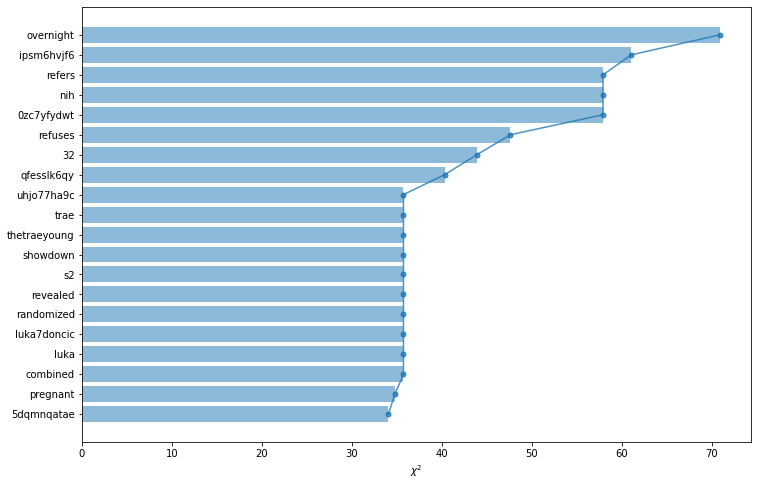

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 

In [67]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), lowercase=True, min_df=2)

X = vectorizer.fit_transform(train_data.Detokenized)

In [82]:
def similar_documents(text, df, n=10):
        df2 = train_data.copy()
        input_vect = vectorizer.transform([text])
        df2['similarity'] = cosine_similarity(input_vect, X).flatten()
        return (df2.sort_values(by='similarity', ascending=False)[['Detokenized', 'similarity', 'reply']].head(n))

In [103]:
user_input = "black science man"
#user_input = """Emotions have really covered the full spectrum, from OK, we can do this, to We ve prepared but maybe we won't get hit too hard, to  Here it comes and we are ready, to This is as bad as we have be"""

pd.set_option('display.max_colwidth', None)
similar_documents(text=user_input, df=train_data, n=50)

Detokenized  \
4620                                                                                [CLS] Want to bone up on how to conduct advanced Web of Science searches? Then check out the @ cunyGClibrary [UNK] s next science research training. Register now https : / / t. co / mznan22bHi @ GCSciences https : / / t. co / OflBmnVTDR [SEP]   
9760                                                                                                                                                                                                                                              [CLS] Are there any black queer or even just black spaces / events in Glasgow? [SEP]   
9761                                                                                                                                                                                                                                              [CLS] Are there any black queer or even just black spaces / events in Glasgow? [SEP]   
4926                                                                                                                                                                                  [CLS] That [UNK] s black people profiting off the black experience. And for you to say this with a Boondocks profile picture is HILARIOUS. [SEP]   
8191                                                                                                                                                                   [CLS] RT @ Coelasquid : Grease isn't a movie about Sandy changing herself for a man, it's about Sandy learning that wearing black leather is fun an [UNK] [SEP]   
8363                                                                                                                                                            [CLS] RT @ RiverHawksWBK : In celebration of Black History Month, we [UNK] ll be donning our black road uniforms. Come join us at 5 : 30 in the event cent [UNK] [SEP]   
4448                                                                                                                                                                                                                                                                                       [CLS] Me to my man for no reason..... [SEP]   
6809                                                                                                                                                                                [CLS] RT @ KingJames : Man o man I wish we were able to have our parade too cause I would have been walking beautifully just like you! [UNK] [SEP]   
11797                                                                                                                                                                                                                                                  [CLS] RT @ CAPYBARA _ MAN : Personal space https : / / t. co / q7LryvTf0E [SEP]   
7424                                                                                                                                                                                               [CLS] RT @ d _ xaivy : @ SGuarddag @ LemonJooJoo A wise man once said... ¶ " Swiggety Swooty " https : / / t. co / ersmd7FNGj [SEP]   
2366                                                                                                                                                                                       [CLS] Connecticut man dies in snowmobile crash in Dallas Plantation ¶ ¶ https : / / t. co / N6GapMUVAt https : / / t. co / NqvOYbPFb7 [SEP]   
7275                                                                                                                                                                   [CLS] RT @ votevets : There used to be a day when Republicans would celebrate this man instead of celebrate and defend the man who sent a mob to th [UNK] [SEP]   
7276                     